In [1]:
push!(LOAD_PATH, "/Users/jayyao/Documents/Research/TraceFormula/Module")
using GridapEM
using Gridap
using DelimitedFiles
using KrylovKit
using LinearAlgebra
using GridapMakie
using GLMakie

In [2]:
include("/Users/jayyao/Documents/Research/TraceFormula/Module/DefaultParameters.jl")

# Change default geometry parameters
L = 0.6           # Length of the normal region
resol = 40.0      # Number of points per wavelength
l1 = λ/resol      # Normal region
l2 = l1/2.0       # Design region
l3 = 2*l1         # PML

# Create mesh file
# geo_param = CirRecGeometry(L, H, rd, rt, dpml, l1, l2, l3)
geo_param = PeriodicGeometry(L, h1, h2, h3, ht, hs, dpml, l1, l2, l3)
meshfile_name = "geometry.msh"
# MeshGenerator(geo_param, meshfile_name)

# Apply gridap finite element analysis to mesh file
gridap = GridapFE(meshfile_name, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)
#run(`gmsh geometry.msh`)

# Change default physics parameters
kb = VectorValue(2*π*0.,0)
ϵ2 = 2.25         # Relative electric permittivity for material 2
σ1 = -3 / 4 * log(R) / dpml / √ϵ1
σ2 = -3 / 4 * log(R) / dpml / √ϵ2
σs = [σ1, σ2]

LHp=[Inf, h1 + h2]  # Start of PML for x,y > 0
LHn=[Inf, h3]  # Start of PML for x,y < 0

phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)

# Change default control parameters
Bρ = false
ρv = 1.0
β = 80.0
K = 5
Amp = 100
control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)



Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 6011 nodes
Info    : 11856 elements
Info    : Done reading 'geometry.msh'


ControllingParameters(true, true, [0.02, 0.02], 80.0, 0.5, 0.0005, 15, 30, 5, 100.0, false, 1.0, 0.0, 0.75, 0.25)

Info    : Reading 'InitialGuess/geometry.msh'...
Info    : 45 entities
Info    : 2463 nodes
Info    : 4820 elements
Info    : Done reading 'InitialGuess/geometry.msh'


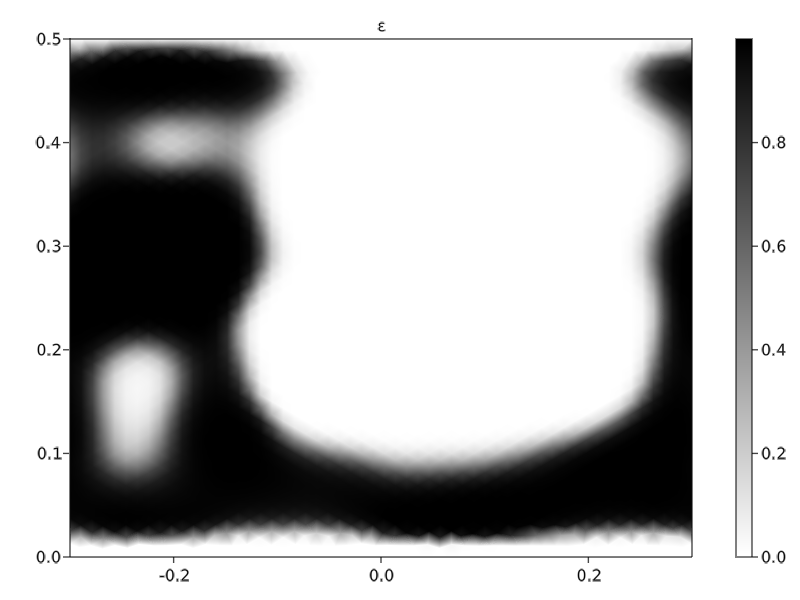

In [3]:
ρ_init = Interpolated_Initial_Guess(gridap)
ρf_vec = ρf_ρ0(ρ_init; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
fig, ax, plt = plot(gridap.Ω, ρth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(h2))
ax.title = "ε"
limits!(ax, -L/2, L/2, 0, h2)
fig

In [3]:
# ρ_init = ones(gridap.np) * 0.5 
# ρW_temp = readdlm("ρW_opt_value.txt", Float64)
# ρW_temp = ρW_temp[:]
# ρ_init = ρW_temp[1 : gridap.np]
# ρ_init[ρ_init .< 0.5] .= 0
# ρ_init[ρ_init .>= 0.5] .= 1.0
# r = [0.02 * λ, 0.02 * λ]  # Filter radius
# Q_list = [10, 20, 50, 100, 500, 1000, 1000]
Q_list = [1000, 1000, 1000, 1000, 1000]
β_list = [80.0, 80.0, 80.0, 80.0, 80.0]
# β_list = [10.0, 20.0, 40.0, 60.0, 80.0, 80.0, 80.0]
# nkx_list = [30, 30, 30, 50, 50, 100, 100]
nkx_list = [100, 100]

g_opt = 0
L_local = L
Li = L
#ρW_temp = readdlm("ρW_opt_value.txt", Float64)
# ρ_init = [0.5] # ρW_temp[1 : gridap.np]
geo_param = PeriodicGeometry(Li, h1, h2, h3, ht, hs, dpml, l1, l2, l3)
# phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)
for bi = 2 : 2
    nkx = nkx_list[bi]
    nparts = nkx / 2
    β = β_list[bi]
    α = 1.0 / (2 * Q_list[bi])
    K = 5
    Amp = 10
    # phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)

    if bi==1
        g_opt, ρW_opt = gρWk_optimize(ρ_init, L_local, 1e-12, 50; geo_param, phys, control)
        L_local = Li
    else
        g_opt, ρW_opt = gρWk_optimize([], L_local, 1e-12, 80; geo_param, phys, control)
        L_local = Li
    end
    if isfile("ρW_opt.value.txt")
        run(`rm ρW_opt_value.txt`)
    end
    open("ρW_opt_value.txt", "w") do iop
        for i = 1 : length(ρW_opt)
            ρW_temp = ρW_opt[i]
            write(iop, "$ρW_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt / Li
gridap = GridapFE(meshfile_name, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)

# Output and view
N = num_free_dofs(gridap.FE_U)
ρW_max = readdlm("ρW_opt_value.txt", Float64)
ρW_max = ρW_max[:]
ρ0 = ρW_max[1 : gridap.np]
W_mat = reinterpret(ComplexF64, reshape(ρW_max[gridap.np + 1 : end], (2 * N, control.K)))


ρf_vec = ρf_ρ0(ρ0; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh

A_mat = MatrixA(ρth; phys, control, gridap)
B_mat = MatrixB(ρth; control, gridap)

A0_mat = MatrixA0(phys, control, gridap)
O_mat = MatrixOl(phys.k, phys.ϵ1; gridap)

G_ii, V_raw, info = eigsolve(x -> A_mat \ (A0_mat * x), rand(ComplexF64, N), control.K, :LM)

V_mat = rand(ComplexF64, N, control.K)
for ib = 1 : min(control.K, control.K)
   V_mat[:, ib] = V_raw[ib]
end
U_mat = A_mat \ (B_mat * W_mat)
uh_eig = FEFunction(gridap.FE_U, V_mat[:, 1])
uh = FEFunction(gridap.FE_U, U_mat[:, 1])

fig, ax, plt = plot(gridap.Ω, real(1 + 11 * ρth), colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(h2))
ax.title = "ε"
limits!(ax, -L/2, L/2, 0, h2)
save("Results/shape_$(Li).png", fig)

Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 6011 nodes
Info    : 11856 elements
Info    : Done reading 'geometry.msh'
numevals = opt.numevals = 80
g_opt / Li = 34.78797978118204
Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 6011 nodes
Info    : 11856 elements
Info    : Done reading 'geometry.msh'


GLMakie.Screen(...)

In [ ]:
# ρ_init = ones(gridap.np) * 0.5 
# ρW_temp = readdlm("ρW_opt_value.txt", Float64)
# ρW_temp = ρW_temp[:]
# ρ_init = ρW_temp[1 : gridap.np]
# ρ_init[ρ_init .< 0.5] .= 0
# ρ_init[ρ_init .>= 0.5] .= 1.0
# r = [0.02 * λ, 0.02 * λ]  # Filter radius
Q_list = [10, 20, 50, 100, 500, 1000, 1000]
# Q_list = [1000, 1000, 1000, 1000, 1000]
# β_list = [80.0, 80.0, 80.0, 80.0, 80.0]
β_list = [10.0, 20.0, 40.0, 60.0, 80.0, 80.0, 80.0]
nkx_list = [30, 30, 30, 50, 50, 100, 100]

g_opt = 0
L_local = L
NL = 1
L_list = zeros(NL)
for li = 1 : NL
    Li = L - (li - 1) * 0.1
    L_list[li] = Li
    #ρW_temp = readdlm("ρW_opt_value.txt", Float64)
    ρ_init = [0.5] # ρW_temp[1 : gridap.np]
    geo_param = PeriodicGeometry(Li, h1, h2, h3, ht, hs, dpml, l1, l2, l3)
    # phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)
    for bi = 6 : 6
        nkx = nkx_list[bi]
        nparts = nkx / 2
        β = β_list[bi]
        α = 1.0 / (2 * Q_list[bi])
        K = 5
        Amp = 100
        # phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)
        control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bρ, ρv, c, ηe, ηd)

        if bi==1
            g_opt, ρW_opt = gρWk_optimize(ρ_init, L_local, 1e-6, 200; geo_param, phys, control)
            L_local = Li
        else
            g_opt, ρW_opt = gρWk_optimize([], L_local, 1e-6, 200; geo_param, phys, control)
            L_local = Li
        end
        if isfile("ρW_opt.value.txt")
            run(`rm ρW_opt_value.txt`)
        end
        open("ρW_opt_value.txt", "w") do iop
            for i = 1 : length(ρW_opt)
                ρW_temp = ρW_opt[i]
                write(iop, "$ρW_temp \n")
            end
        end
        open("g_opt_value.txt", "a") do io
            write(io, "$g_opt \n")
        end
    end
    @show g_opt / Li
    gridap = GridapFE(meshfile_name, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)
    
    # Output and view
    N = num_free_dofs(gridap.FE_U)
    ρW_max = readdlm("ρW_opt_value.txt", Float64)
    ρW_max = ρW_max[:]
    ρ0 = ρW_max[1 : gridap.np]
    W_mat = reinterpret(ComplexF64, reshape(ρW_max[gridap.np + 1 : end], (2 * N, control.K)))
    
 
    ρf_vec = ρf_ρ0(ρ0; control, gridap)
    ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
    ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
        
    # A_mat = MatrixA(ρth; phys, control, gridap)
    # B_mat = MatrixB(ρth; control, gridap)

    # A0_mat = MatrixA0(phys, control, gridap)
    # O_mat = MatrixOl(phys.k, phys.ϵ1; gridap)

    # G_ii, V_raw, info = eigsolve(x -> A_mat \ (A0_mat * x), rand(ComplexF64, N), 10, :LM)

    # V_mat = rand(ComplexF64, N, control.K)
    # for ib = 1 : min(control.K, 10)
    #    V_mat[:, ib] = V_raw[ib]
    # end
    # U_mat = A_mat \ (B_mat * W_mat)
    # uh_eig = FEFunction(gridap.FE_U, V_mat[:, 1])
    # uh = FEFunction(gridap.FE_U, U_mat[:, 1])

    fig, ax, plt = plot(gridap.Ω, real(1 + 11 * ρth), colormap = :binary)
    Colorbar(fig[1,2], plt)
    ax.aspect = AxisAspect(L/(phys.LHn[2] + phys.LHp[2]))
    ax.title = "ε"
    limits!(ax, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
    save("Results/shape_$(Li).png", fig)
end

sum(∫(ρth) * gridap.dΩ_d) / sum(∫(1) * gridap.dΩ_d) = 0.43035604950051365


┌ Warning: Invariant subspace of dimension 4 (up to requested tolerance `tol = 1.0e-12`), which is smaller than the number of requested eigenvalues (i.e. `howmany == 5`); setting `howmany = 4`.
└ @ KrylovKit /Users/jayyao/.julia/packages/KrylovKit/YPiz7/src/eigsolve/arnoldi.jl:176


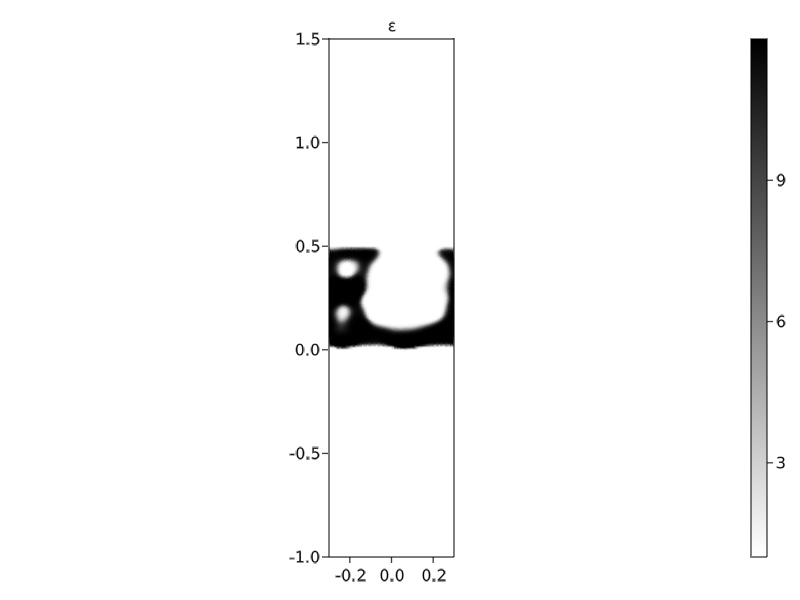

In [4]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    ρW_max = readdlm("ρW_opt_value.txt", Float64)
    ρW_max = ρW_max[:]
    ρ0 = ρW_max[1 : gridap.np]
    W_mat = reinterpret(ComplexF64, reshape(ρW_max[gridap.np + 1 : end], (2 * N, control.K)))
else
    ρ0 = ones(gridap.np)
end
 
ρf_vec = ρf_ρ0(ρ0; control, gridap)
ρfh = FEFunction(gridap.FE_Pf, ρf_vec)
ρth = (ρf -> Threshold(ρf; control)) ∘ ρfh
        
A_mat = MatrixA(ρth; phys, control, gridap)
B_mat = MatrixB(ρth; control, gridap)
@show sum(∫(ρth)gridap.dΩ_d) / sum(∫(1)gridap.dΩ_d)

A0_mat = MatrixA0(phys, control, gridap)
O_mat = MatrixOl(phys.k, phys.ϵ1; gridap)

G_ii, V_raw, info = eigsolve(x -> A_mat \ (A0_mat * x), rand(ComplexF64, N), 10, :LM)
G_trace, W_raw, info = eigsolve(x -> MatrixG(x; A_mat, B_mat, O_mat), rand(ComplexF64, N), min(control.K, 10), :LM; krylovdim = 30)
if !ImportFromFile
    W_mat = rand(ComplexF64, N, control.K)
    for ib = 1 : control.K
        W_mat[:, ib] = W_raw[ib]
    end
end


V_mat = rand(ComplexF64, N, control.K)
for ib = 1 : min(control.K, 10)
    V_mat[:, ib] = V_raw[ib]
end
U_mat = A_mat \ (B_mat * W_mat)
uh_eig = FEFunction(gridap.FE_U, V_mat[:, 1])
uh = FEFunction(gridap.FE_U, U_mat[:, 1])

fig, ax, plt = plot(gridap.Ω, real(1 + 11 * ρth), colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(phys.LHn[2] + phys.LHp[2]))
ax.title = "ε"
limits!(ax, -L/2, L/2, -phys.LHn[2], phys.LHp[2])
save("Results/shape.png", fig)
fig

In [4]:
L = 1.0
nkx = 100
kx_ini = -π/L
dkx = 2*π/L/nkx
kx_end = π/L-dkx
kx_s = range(kx_ini,kx_end;length=nkx)

gk = zeros(nkx)
Giik = zeros(nkx)

for ki = 1 : nkx
    kx=kx_s[ki]
    kb = VectorValue(kx, 0.0)    
    physk = PhysicalParameters(phys.k, kb, phys.ω, phys.ϵ1, phys.ϵ2, phys.ϵ3, phys.ϵd, phys.μ, phys.R, phys.σs, phys.dpml, phys.LHp, phys.LHn, phys.wg_center, phys.wg_size)
    A_matk = MatrixA(ρth; phys=physk, control, gridap)
    G_ii, W_raw, info = eigsolve(x->MatrixG(x; A_mat=A_matk, B_mat, O_mat), rand(ComplexF64,N), 4, :LM)
    Giik[ki] = sum(abs.(G_ii))
    W_mat = rand(ComplexF64, N, control.K)
    for ib = 1 : 4
        W_mat[:, ib] = W_raw[ib]
    end
    gk[ki] = g_ρ(ρ0; O_mat, W_mat, phys=physk, control, gridap)
end
sum(gk)/nkx/L, sum(Giik)/nkx/L

(20.577789909325052, 20.5777915871647)

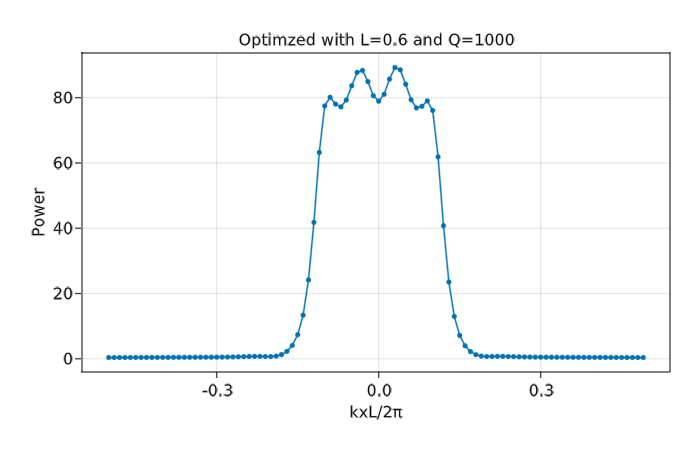

In [5]:

scene, layout = layoutscene(resolution=(1400/2,900/2))
ax = layout[1,1]=Axis(scene)
lin1 = scatter!(ax,kx_s[:]./(2*π/L),gk[:]./L,markersize=5)
lin2 = lines!(ax,kx_s[:]./(2*π/L),Giik[:]./L)
ax.ylabel="Power"
ax.xlabel="kxL/2π"
ax.title="Optimzed with L=0.6 and Q=1000"
save("Results/L0.6_gvsk.png",scene)
scene

In [6]:
G_iin, V_raw, info = eigsolve(x->MatrixGk(x, ρth; O_mat, kx_s, phys, control, gridap), rand(ComplexF64,N), 4, :LM)
sum(abs.(G_iin))

20.577789909571685

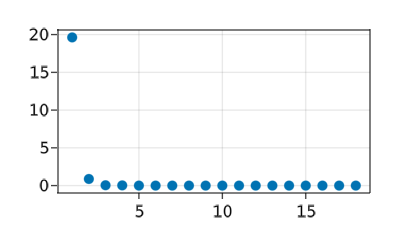

In [7]:
scene, layout = layoutscene(resolution=(800/2,500/2))
ax = layout[1,1]=Axis(scene)
lin1 = scatter!(ax,range(1,length(G_iin),step=1),abs.(G_iin)/L,markersize=10)
#ax.xlabel="i'th eigenvalue"
#ax.ylabel="Value"
#ax.title="Power Eigenvalue Distribution"
#ax.xlabelsize=20
#ax.ylabelsize=20
#ax.titlesize=20
#axislegend(ax, [lin1, lin2],["Optimized","Random"], position = :lt,
#    orientation = :vertical)
scene

In [ ]:
using PartitionedArrays
N = num_free_dofs(gridap.FE_U)
ρW0 = rand(gridap.np + 2 * N * control.K)
δρW = rand(gridap.np + 2 * N * control.K) * 1e-6

kx_ini = -π / geo_param.L
dkx = 2 * π / geo_param.L / control.nkx
kx_end = π / geo_param.L - dkx
kx_s = range(kx_ini, kx_end; length = control.nkx)
backend = SequentialBackend()
parts = get_part_ids(backend, control.nparts)
prange = PRange(parts, control.nkx)
ids = map_parts(get_lid_to_gid, prange.partition)

O_mat = MatrixOl(phys.k, phys.ϵ1; gridap)

grad = zeros(gridap.np + 2 * N * control.K)
g0 = gρW_sumk(ρW0, grad; ids, kx_s, dkx, O_mat, phys, control, gridap)
g1 = gρW_sumk(ρW0 + δρW, []; ids, kx_s, dkx, O_mat, phys, control, gridap)
g1 - g0, grad' * δρW